Cada LLM call procesa el output del previo. Sirve bien cuando hay well-defined tasks que se puede 

# Imports

In [17]:
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

from dotenv import load_dotenv
load_dotenv()

True

# Modelo

In [24]:
llm = init_chat_model(model="gpt-5-nano")
llm.invoke("What is the capital of France?")

AIMessage(content='Paris', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 266, 'prompt_tokens': 13, 'total_tokens': 279, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CaAtyOLS1NvVzjEAAdNMIiJkJj9tk', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--26648a28-e79b-4b75-870d-d1f707c18df7-0', usage_metadata={'input_tokens': 13, 'output_tokens': 266, 'total_tokens': 279, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 256}})

# Graph State

In [7]:
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

# Nodos

In [9]:
def generate_joke(state: State):
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

In [8]:
def check_punchline(state: State):
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

In [10]:
def improve_joke(state: State):
    msg = llm.invoke(f"Write this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

In [11]:
def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Worflow

In [19]:
workflow = StateGraph(State)

In [20]:
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

In [21]:
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke",
    check_punchline,
    {
        "Fail": "improve_joke",
        "Pass": END,
    }
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

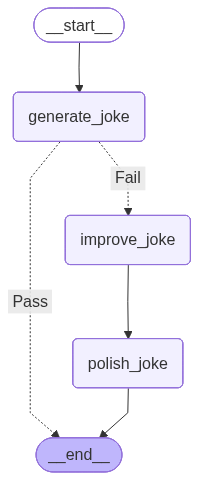

In [22]:
chain = workflow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

In [30]:
state = chain.invoke({"topic": "dogs without ? or !"})
state

{'topic': 'dogs without ? or !',
 'joke': 'My dog started a bakery and calls it the barkery.',
 'improved_joke': 'Here are a few pun-packed rewrites. Pick your vibe or mix and match:\n\n- My dog started a bakery and calls it the barkery. It’s paw-sitively delicious—every loaf is fetched fresh, and the compliments come back wagging.\n\n- Step into the barkery: Sit. Stay. Knead. And watch your bread fetch itself—now that’s a doggone good bakery.\n\n- My dog started a bakery and calls it the barkery. It’s the only place where the bread comes when you call it—talk about a retriever deal.\n\n- At the barkery, we bake with love and a little bark-back. Every pastry is paw-some and every customer leaves with a wag.\n\n- Customer: “Do you take orders?” Dog: “Sure—sit, stay, knead.” Welcome to the barkery.',
 'final_joke': "Fun idea to punch up the set. Here are a few surprising twist endings you can drop in (or mix with your lines) to flip the expectation in a wink:\n\n- Twist 1: It’s actually 